In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score   
from transformers import pipeline
from torch.optim import Adam
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import gc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 2 group  / skincare data
df = pd.read_csv('/home/ubuntu/w266/balanced_skincare_10k.csv')
df.columns = ['review_text', 'age_range']
# df = df.iloc[:1000]
df

,review_text,age_range
0,100% would recommend. Got this as a sample and...,0
1,"10/10 cleanser. Doesn^t dry skin out, smells a...",0
2,10/10!! I absolutely love this!!! I got it as...,0
3,1st off I already loved the name and just espe...,0
4,"1. super easy to use!! I love peels, so effici...",0
...,...,...
9995,I bought this last month and have used it prim...,1
9996,I bought this last week along with some more D...,1
9997,I bought this last year.... I did not want to ...,1
9998,I bought this lip gloss on a whim online after...,1


In [3]:
df.groupby('age_range').describe()

review_text         \
                count unique   
age_range                      
0                5000   5000   
1                5000   5000   

                                                                   
                                                         top freq  
age_range                                                          
0          100% would recommend. Got this as a sample and...    1  
1          - 0.34 oz/ 10 mL Superscreen Daily Moisturizer...    1

In [4]:
# adding special tokens at the beginning and end of each sentence for BERT to work properly
reviews = df.review_text.values
reviews = ["[CLS] " + review + " [SEP]" for review in reviews]
age_range = df.age_range.values

In [5]:
%%time
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_texts = [tokenizer.tokenize(review) for review in reviews]
print ("Tokenize the first review:")
print (tokenized_texts[0])

Tokenize the first review:
['[CLS]', '100', '%', 'would', 'recommend', '.', 'got', 'this', 'as', 'a', 'sample', 'and', 'i', 'never', 'even', 'knew', 'i', 'needed', 'it', 'until', 'i', 'tried', 'it', '.', 'takes', 'off', 'all', 'your', 'makeup', 'ever', 'so', 'gently', 'and', 'breaks', 'it', 'right', 'down', 'and', 'then', 'you', 'just', 'clean', '##se', 'your', 'face', 'after', 'as', 'you', 'would', 'usually', '.', 'do', 'at', 'least', 'get', 'a', 'sample', 'and', 'try', 'it', 'out', ',', 'the', 'texture', 'of', 'it', 'is', 'me', '##sm', '##eri', '##zing', 'and', 'does', 'such', 'a', 'good', 'job', '!', '[SEP]']
CPU times: user 13.5 s, sys: 69.2 ms, total: 13.6 s
Wall time: 13.9 s


In [6]:
# Maximum sequence length
MAX_LEN = 400

In [7]:
# check maximum sequence length of our data
real_max_len = 0
for i in tokenized_texts:
    iter_len = len(i)
    if real_max_len < iter_len:
        real_max_len = iter_len
    else:
        pass

real_max_len

659

In [8]:
%%time
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (659 > 512). Running this sequence through BERT will result in indexing errors


CPU times: user 236 ms, sys: 8.15 ms, total: 244 ms
Wall time: 242 ms


In [9]:
%%time
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

CPU times: user 83.3 ms, sys: 12 ms, total: 95.3 ms
Wall time: 93.1 ms


In [10]:
# input_ids
input_ids.shape

(10000, 400)

In [11]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [12]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, age_range, 
                                                            random_state=2022, test_size=0.33)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2022, test_size=0.33)

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [15]:
# Manage GPU memory
gc.collect()
torch.cuda.empty_cache()

In [16]:
%%time
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

CPU times: user 8.15 s, sys: 1.94 s, total: 10.1 s
Wall time: 10.2 s


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [17]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [18]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = Adam(optimizer_grouped_parameters,
                     lr=2e-5)

In [19]:
# # This variable contains all of the hyperparemeter information our training loop needs
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



In [21]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [22]:
# Manage GPU memory OOM
gc.collect()
torch.cuda.empty_cache()

In [23]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# f1_score_list & precision_score_list & recall_score_list
f1_score_list, precision_score_list, recall_score_list = [], [], []

logits_list = []
labels_list = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
#         print('step: ', step)
    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
#     print('validation_dataloader:  ', len(validation_dataloader))
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        logits_list.append(logits)
        labels_list.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        # f1_score(labels, predicts)
        
#         iter_f1_score = f1_score(label_ids, logits)
#         iter_precision_score = precision_score(label_ids, logits)
#         iter_recall_score = recall_score(label_ids, logits)
#         f1_score_list.append(iter_f1_score)
#         precision_score_list.append(iter_precision_score)
#         recall_score_list.append(iter_recall_score)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.4506625060169999


Epoch: 100%|██████████| 1/1 [21:53<00:00, 1313.17s/it]

Validation Accuracy: 0.8524242424242424


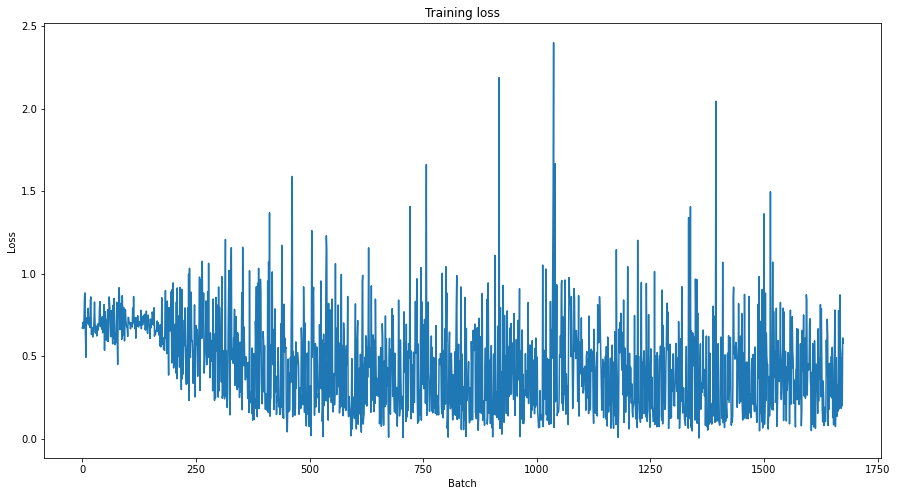

In [24]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [25]:
len(logits_list)
len(labels_list)


825

In [26]:
train_loss_set

[0.6712384819984436,
 0.6697153449058533,
 0.7055606842041016,
 0.6675571203231812,
 0.7297078371047974,
 0.8580184578895569,
 0.883037805557251,
 0.641566276550293,
 0.4927208721637726,
 0.7044218182563782,
 0.7322612404823303,
 0.6989365816116333,
 0.6978106498718262,
 0.7897207736968994,
 0.6896349787712097,
 0.7331631183624268,
 0.7236425280570984,
 0.673630952835083,
 0.8401830792427063,
 0.8590457439422607,
 0.6322489380836487,
 0.6406182050704956,
 0.6730101704597473,
 0.6158404350280762,
 0.6528136730194092,
 0.6437627673149109,
 0.7440992593765259,
 0.8277952671051025,
 0.7141688466072083,
 0.6434308886528015,
 0.6387190818786621,
 0.6811459064483643,
 0.6219831705093384,
 0.6563467979431152,
 0.6949443221092224,
 0.6574735641479492,
 0.6892129778862,
 0.6968057155609131,
 0.793404221534729,
 0.8303165435791016,
 0.6788837909698486,
 0.7053815126419067,
 0.6902991533279419,
 0.663398265838623,
 0.7386780977249146,
 0.6408897042274475,
 0.6799352169036865,
 0.6951565742492676,


In [27]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [28]:
np.argmax(logits_list[0], axis=1).flatten()

array([1, 1, 1, 1])

In [29]:
a = logits_list[0][0]
b = labels_list[0][0]

In [30]:
PATH = '/home/ubuntu/w266/model/skincare_adam_10k.txt'

In [31]:
torch.save(model.state_dict(), PATH)